In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

In [3]:
!pip install seaborn
import seaborn as sns

In [4]:
df = pd.read_csv('D:\ISE540\Team project\Amazonfoodnew - Amazonfoodnew.csv')
df.fillna(0, inplace=True)

In [5]:
selected_columns = ['reviewText','relevance_score','packing/outter appearance/shipping','health/ingredient','pricing/volume/quality','Cooking/how to use','Taste/texture']
df = df[selected_columns]

(1) EDA

In [6]:
df

,reviewText,relevance_score,packing/outter appearance/shipping,health/ingredient,pricing/volume/quality,Cooking/how to use,Taste/texture
0,Lovely stuff. Makes up quickly in a French pr...,3.0,0.0,0.0,0.0,0.0,1.0
1,"Came in on expected date, the packaging was fa...",4.0,1.0,0.0,0.0,1.0,1.0
2,Good Product.,1.0,0.0,0.0,0.0,0.0,0.0
3,Tasty snack. Deducted one star as while the p...,4.0,0.0,0.0,0.0,0.0,-1.0
4,Coffee was weak and had a burnt flavor,3.0,0.0,0.0,0.0,0.0,-1.0
...,...,...,...,...,...,...,...
1995,these are delish and can feed a family of 5 wi...,2.0,0.0,0.0,1.0,0.0,0.0
1996,Yum,0.0,0.0,0.0,0.0,0.0,0.0
1997,This is by far the best coffee I have ever tas...,3.0,0.0,0.0,0.0,0.0,1.0
1998,I purchased this coffee for my husband and I t...,4.0,0.0,0.0,0.0,0.0,1.0


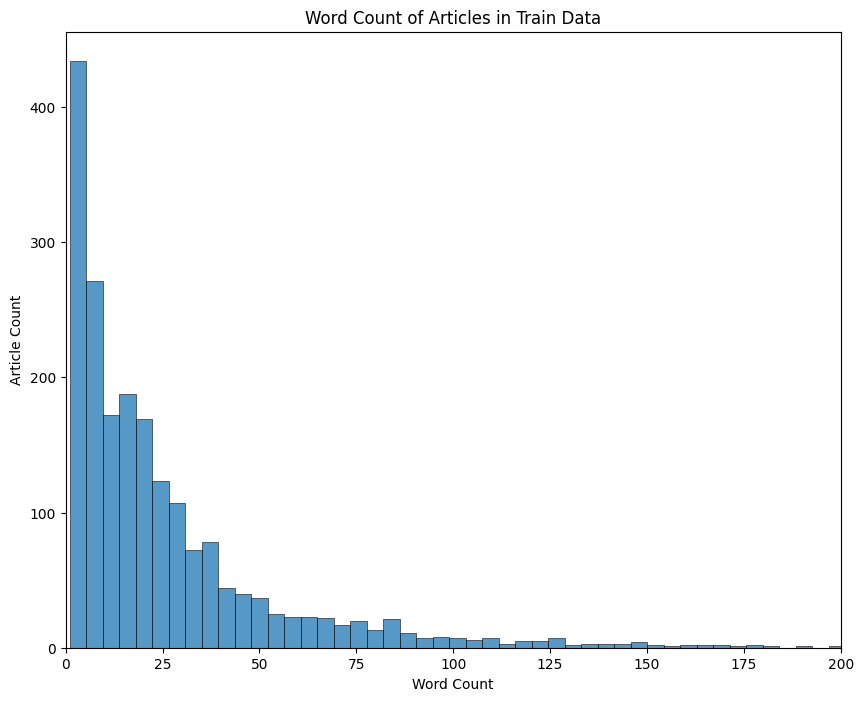

In [7]:
df['word_count'] = df['reviewText'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(10,8))
sns.histplot(data=df, x='word_count')
plt.xlim(0, 200)
plt.title('Word Count of Articles in Train Data')
plt.xlabel('Word Count')
plt.ylabel('Article Count')
plt.show()

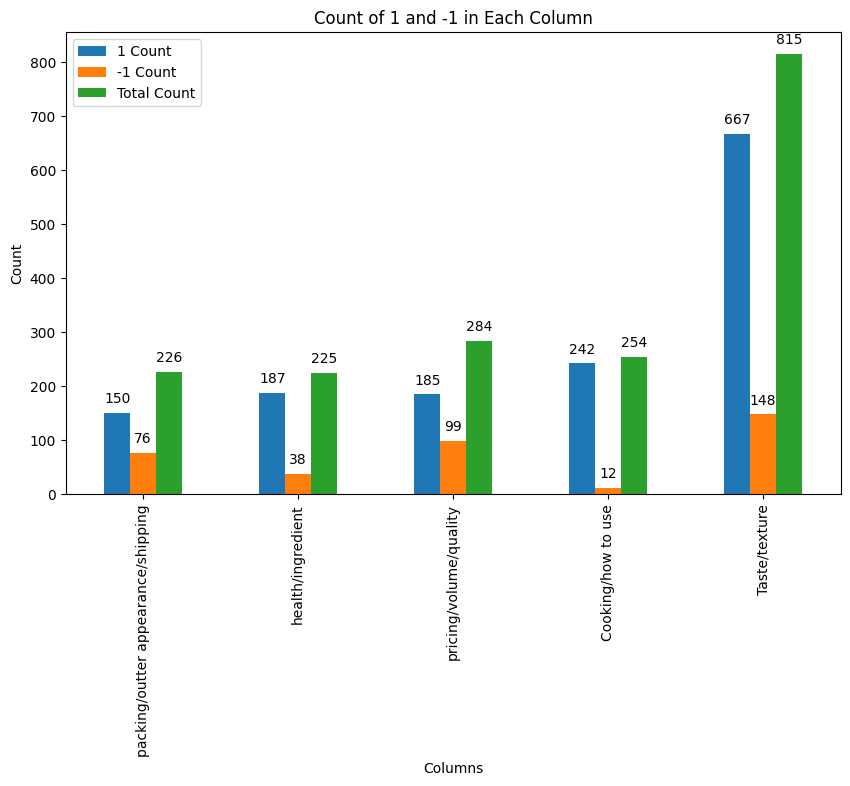

In [8]:
cols = ['packing/outter appearance/shipping','health/ingredient','pricing/volume/quality','Cooking/how to use','Taste/texture']  # 替换成你实际的列名

# 创建一个空的 DataFrame 用于存储统计结果
summary_df = pd.DataFrame(index=cols, columns=['1 Count', '-1 Count', 'Total Count'])

# 统计每一列中 1 和 -1 的数量
for col in cols:
    ones_count = df[col].eq(1).sum()
    minus_ones_count = df[col].eq(-1).sum()
    total_count = ones_count + minus_ones_count

    # 将统计结果存储到 summary_df 中
    summary_df.loc[col] = [ones_count, minus_ones_count, total_count]

# 绘制条形图
ax = summary_df.plot(kind='bar', figsize=(10, 6))
plt.title('Count of 1 and -1 in Each Column')
plt.xlabel('Columns')
plt.ylabel('Count')

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

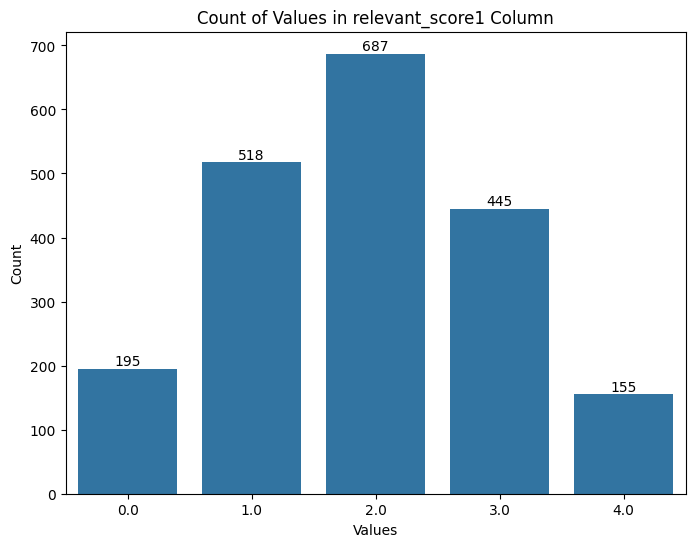

In [9]:
relevant_score1_counts = df['relevance_score'].value_counts().sort_index()

# 创建一个包含统计结果的 DataFrame
summary_df = pd.DataFrame({
    'Value': relevant_score1_counts.index,
    'Count': relevant_score1_counts.values
})

# 绘制 relevant_score1 列中 1 到 4 的数量条形图
plt.figure(figsize=(8, 6))
sns.barplot(data=summary_df, x='Value', y='Count')
plt.title('Count of Values in relevant_score1 Column')
plt.xlabel('Values')
plt.ylabel('Count')

# 在每个条形上显示数值标签
for index, value in enumerate(summary_df['Count']):
    plt.text(index, value + 0.1, str(value), ha='center', va='bottom')

plt.show()


(2) Data cleaning and preprocessing

In [10]:
import os
import re
import nltk
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.datasets import fetch_20newsgroups
from keras import layers
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [11]:
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")
nltk.download("stopwords")
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\12483\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\12483\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\12483\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\12483\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\12483\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [12]:
!pip install tensorflow

In [13]:
def get_wordnet_pos (tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [14]:
def lemmatize (word_list):
    wl = WordNetLemmatizer()
    word_pos_tags = pos_tag(word_list)
    lemmatized_list = []
    for tag in word_pos_tags:
        lemmatize_word = wl.lemmatize(tag[0],get_wordnet_pos(tag[1]))
        lemmatized_list.append(lemmatize_word)
    return " ".join(lemmatized_list)

In [37]:
def clean_text (text):
    # Remove Pre and Post Spaces
    text = str(text).strip()
    
    # Lower case the entire text
    text = str(text).lower()

    # Substitute New Line Characters with spaces 
    text = re.sub(r"\n", r" ", text)
        
    # Tokenize the sentence
    word_tokens = word_tokenize(text)
    
    # Remove the punctuation and  special characters from each individual word
    cleaned_text = []
    for word in word_tokens:
        cleaned_text.append("".join([char for char in word if char.isalnum()]))
    
    # Specify the stop words list
    stop_words = stopwords.words('english')
    
    # Remove the stopwords and words containing less then 2 characters
    text_tokens = [word for word in cleaned_text if (len(word) > 2) and (word in important_words)]
    # text_tokens = [word for word in cleaned_text if (len(word) > 2)and (word not in stop_words)]
    #Lemmatize each word in the word list
    text = lemmatize (text_tokens)
    
    return text

In [137]:
new_df = df.replace(-1, 1)

In [16]:
len(df['reviewText'][1])

488

In [38]:
len(clean_text(df['reviewText'][1]))

156

In [20]:
df['reviewText'][1]

"Came in on expected date, the packaging was fantastic I can't complain. Kinda disappointed though that it didn't come in a bag like the picture shows, candy was slightly melted but that is my fault I wasn't able to get to my mailbox right after delivery, and the Texas heat got them. I put them in the fridge and they were the exact same texture as I had hoped for! Very creamy and decadent almost melt in your mouth. I can't wait to order more. Only downfall is it takes a while to ship."

In [21]:
clean_text(df['reviewText'][1])

'come expect date packaging fantastic complain kinda disappoint though come bag like picture show candy slightly melt fault able get mailbox right delivery texas heat get put fridge exact texture hop creamy decadent almost melt mouth wait order downfall take ship'

In [22]:
import swifter

d:\Anaconda3\envs\d21\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [39]:
df['reviewText'] = df['reviewText'].swifter.apply(lambda x: clean_text(x))

Pandas Apply: 100%|██████████| 2000/2000 [00:02<00:00, 981.54it/s] 


In [138]:
new_df['reviewText'] = new_df['reviewText'].swifter.apply(lambda x: clean_text(x))

Pandas Apply: 100%|██████████| 2000/2000 [00:02<00:00, 952.25it/s]


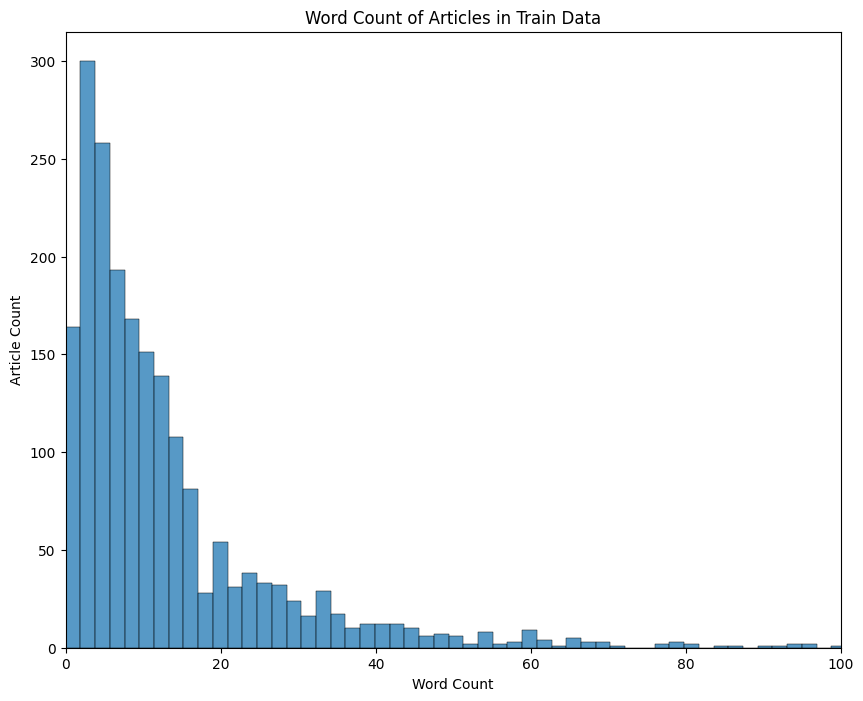

In [24]:
df['word_count'] = df['reviewText'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(10,8))
sns.histplot(data=df, x='word_count')
plt.xlim(0, 100)
plt.title('Word Count of Articles in Train Data')
plt.xlabel('Word Count')
plt.ylabel('Article Count')
plt.show()

(3) Train and test split

In [25]:
from random import shuffle
def shuffle_data(relevant, train_ratio=0.7):
    indices = list(relevant.index)
    shuffle(indices)
    relevant_shuffled = relevant.loc[indices].reset_index(drop=True)
    
    n = len(relevant_shuffled)
    train_size = int(train_ratio * n)
    df_train = relevant_shuffled.iloc[:train_size]
    df_test = relevant_shuffled.iloc[train_size:]
    return df_train, df_test

In [40]:
df_train, df_test = shuffle_data(df)

In [139]:
df_train1, df_test1 = shuffle_data(new_df)

In [27]:
df_test.shape

(600, 8)

In [41]:
list_classes = ['packing/outter appearance/shipping','health/ingredient','pricing/volume/quality','Cooking/how to use','Taste/texture']
train_labels = df_train[list_classes].values
test_labels = df_test[list_classes].values

In [147]:
train_labels1 = df_train1[list_classes].values
test_labels1 = df_test1[list_classes].values

In [42]:
X_train = df_train['reviewText']
X_test = df_test['reviewText']
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", train_labels.shape)
print("y_test:", test_labels.shape)

X_train: (1400,)
X_test: (600,)
y_train: (1400, 5)
y_test: (600, 5)


In [140]:
X_train1 = df_train1['reviewText']
X_test1 = df_test1['reviewText']

In [43]:
tokenizer = Tokenizer(num_words=300)
tokenizer.fit_on_texts(X_train)

In [141]:
tokenizer1 = Tokenizer(num_words=300)
tokenizer1.fit_on_texts(X_train1)

In [44]:
vocab_size = len(tokenizer.word_counts) + 1
print('Vocab Size:', vocab_size)

train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)
print("First Intance Text:\n")
print(X_train[1])
print("\nFirst Intance Total Words:", len(str(X_train[1]).split()))

Vocab Size: 302
First Intance Text:

see back market could ship high order would week day back high black favorite fast receive first day delivery put one would nice around happy take first taste like use love bottle husband happy pay much bottle could whole thing know bottle

First Intance Total Words: 42


In [143]:
vocab_size = len(tokenizer1.word_counts) + 1
print('Vocab Size:', vocab_size)

train_sequences1 = tokenizer.texts_to_sequences(X_train1)
test_sequences1 = tokenizer.texts_to_sequences(X_test1)
print("First Intance Text:\n")
print(X_train1[1])
print("\nFirst Intance Total Words:", len(str(X_train1[1]).split()))

Vocab Size: 300
First Intance Text:

love bar flavor like yet love try many flavor variety box

First Intance Total Words: 11


In [74]:
from keras.preprocessing.sequence import pad_sequences

# Assuming train_sequences is your list of tokenized sequences

# Find the maximum sequence length
# max_sequence_length = max(len(seq) for seq in train_sequences)
max_sequence_length = 75
# Pad sequences
train_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
test_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

In [144]:
max_sequence_length = 75
# Pad sequences
train_sequences1 = pad_sequences(train_sequences1, maxlen=max_sequence_length, padding='post', truncating='post')
test_sequences1 = pad_sequences(test_sequences1, maxlen=max_sequence_length, padding='post', truncating='post')

In [146]:
print("First Intance Text Sequence:\n")
print(train_sequences[0])
print("\nFirst Intance Text Sequence Length:", len(train_sequences[2]))

First Intance Text Sequence:

[7, 53, 15, 195, 6, 55, 15, 6, 83, 289, 6, 106, 3]

First Intance Text Sequence Length: 4


In [36]:
important_words = list(tokenizer.word_index.keys())[:300]

(4) TextCNN model

In [49]:
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.stem import SnowballStemmer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, Embedding, Bidirectional, GRU, Conv1D, GlobalMaxPooling1D, Dropout, TimeDistributed
from keras.layers import concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [65]:
tokenizer.index_word

{1: 'good',
 2: 'great',
 3: 'love',
 4: 'taste',
 5: 'like',
 6: 'flavor',
 7: 'product',
 8: 'use',
 9: 'one',
 10: 'coffee',
 11: 'buy',
 12: 'make',
 13: 'get',
 14: 'tea',
 15: 'try',
 16: 'order',
 17: 'would',
 18: 'well',
 19: 'best',
 20: 'find',
 21: 'price',
 22: 'time',
 23: 'delicious',
 24: 'little',
 25: 'much',
 26: 'really',
 27: 'come',
 28: 'give',
 29: 'quality',
 30: 'bag',
 31: 'purchase',
 32: 'work',
 33: 'eat',
 34: 'box',
 35: 'chocolate',
 36: 'even',
 37: 'nice',
 38: 'store',
 39: 'package',
 40: 'brand',
 41: 'think',
 42: 'favorite',
 43: 'amazon',
 44: 'also',
 45: 'look',
 46: 'fresh',
 47: 'say',
 48: 'add',
 49: 'recommend',
 50: 'excellent',
 51: 'stuff',
 52: 'tasty',
 53: 'first',
 54: 'sweet',
 55: 'could',
 56: 'need',
 57: 'know',
 58: 'way',
 59: 'want',
 60: 'hot',
 61: 'sugar',
 62: 'easy',
 63: 'perfect',
 64: 'drink',
 65: 'take',
 66: 'salt',
 67: 'lot',
 68: 'small',
 69: 'always',
 70: 'cup',
 71: 'sure',
 72: 'water',
 73: 'sauce',
 74:

In [90]:
MAX_SEQUENCE_LENGTH = 75
MAX_NB_WORDS = 301
EMBEDDING_DIM = 10

In [91]:
def get_text_cnn():
    filter_nums = 120
    dense_units = 72
    output_units = 5
    
    input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedding_layer = Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH,trainable=False,)(input_layer)
        
    conv_0 = Conv1D(filter_nums, 2, kernel_initializer="normal", padding="valid", activation="relu")(embedding_layer)
    conv_1 = Conv1D(filter_nums, 3, kernel_initializer="normal", padding="valid", activation="relu")(embedding_layer)
    conv_2 = Conv1D(filter_nums, 4, kernel_initializer="normal", padding="valid", activation="relu")(embedding_layer)

    maxpool_0 = GlobalMaxPooling1D()(conv_0)
    maxpool_1 = GlobalMaxPooling1D()(conv_1)
    maxpool_2 = GlobalMaxPooling1D()(conv_2)

    merged_tensor = concatenate([maxpool_0, maxpool_1, maxpool_2])
    h1 = Dense(units=dense_units, activation="relu")(merged_tensor)
    output = Dense(units=output_units, activation='sigmoid')(h1)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [92]:
def get_hybrid_textnn():
    recurrent_units = 48
    dense_units = 32
    filter_nums = 64
    output_units = 5

    input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,))
    embedding_layer = Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH)(input_layer)
    
    x = Bidirectional(GRU(recurrent_units, return_sequences=True))(embedding_layer)
    x = Conv1D(filter_nums, 2, kernel_initializer="normal", padding="valid", activation="relu")(x)    
    
    max_pool = GlobalMaxPooling1D()(x)
    max_pool = Dropout(0.5)(max_pool)
    
    output_layer = Dense(output_units, activation="sigmoid")(max_pool)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [93]:
def _train_model_by_logloss(model, batch_size, train_x, train_y, val_x, val_y, fold_id):
    # set an early stopping checker.
    # the training phase would stop when validation log loss decreases continuously for `patience` rounds. 
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    bst_model_path = "ToxicModel" + str(fold_id) + '.h5'
    model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)
    
    # training on given fold data
    hist = model.fit(train_x, train_y,
        validation_data=(val_x, val_y),
        epochs=30, batch_size=batch_size, shuffle=True)
#         ,callbacks=[early_stopping, model_checkpoint])
    
    # get the minimal validation log loss on this fold
    bst_val_score = min(hist.history['val_loss'])
#     model.load_weights(bst_model_path)

    # return the model with best weight, best fold-val score
    return model, bst_val_score

def train_folds(X, y, fold_count, batch_size, get_model_func):
    fold_size = len(X) // fold_count
    models = []
    score = 0
    
    # split the whole dataset to `fold_count` fold, and train our model on each fold
    for fold_id in range(0, fold_count):
        fold_start = fold_size * fold_id
        fold_end = fold_start + fold_size

        if fold_id == fold_size - 1:
            fold_end = len(X)

        # Generate the train/val data on fold i
        train_x = np.concatenate([X[:fold_start], X[fold_end:]])
        train_y = np.concatenate([y[:fold_start], y[fold_end:]])

        val_x = X[fold_start:fold_end]
        val_y = y[fold_start:fold_end]
    
        print("Training on fold #", fold_id)
        model, bst_val_score = _train_model_by_logloss(get_model_func(), batch_size, train_x, train_y, val_x, val_y, fold_id)
        score += bst_val_score
        models.append(model)
    return models, score / fold_count

In [55]:
import h5py

In [148]:
models, val_loss = train_folds(X=train_sequences1, y=train_labels1, fold_count=10, batch_size=256, get_model_func=get_text_cnn)

Training on fold # 0
Epoch 1/30
5/5 [==============================] - 1s 71ms/step - loss: 0.6812 - accuracy: 0.1960 - val_loss: 0.6642 - val_accuracy: 0.2214
Epoch 2/30
5/5 [==============================] - 0s 30ms/step - loss: 0.6530 - accuracy: 0.2294 - val_loss: 0.6314 - val_accuracy: 0.2214
Epoch 3/30
5/5 [==============================] - 0s 27ms/step - loss: 0.6185 - accuracy: 0.2294 - val_loss: 0.5913 - val_accuracy: 0.2214
Epoch 4/30
5/5 [==============================] - 0s 26ms/step - loss: 0.5784 - accuracy: 0.2294 - val_loss: 0.5444 - val_accuracy: 0.2214
Epoch 5/30
5/5 [==============================] - 0s 26ms/step - loss: 0.5350 - accuracy: 0.2294 - val_loss: 0.4983 - val_accuracy: 0.2214
Epoch 6/30
5/5 [==============================] - 0s 27ms/step - loss: 0.4984 - accuracy: 0.2294 - val_loss: 0.4614 - val_accuracy: 0.2214
Epoch 7/30
5/5 [==============================] - 0s 28ms/step - loss: 0.4724 - accuracy: 0.2294 - val_loss: 0.4378 - val_accuracy: 0.2214
Epoch 

In [95]:
train_predict = models[-1].predict(train_sequences)
test_predict = models[-1].predict(test_sequences)

19/19 [==============================] - 0s 2ms/step


In [99]:
train_predict.shape

(1400, 5)

In [100]:
test_predict.shape

(600, 5)

In [102]:
CLASSES = ['packing/outter appearance/shipping','health/ingredient','pricing/volume/quality','Cooking/how to use','Taste/texture']
print("Predicting testing results...")
test_predicts_list = []
for fold_id, model in enumerate(models):
    test_predicts = model.predict(test_sequences, batch_size=256, verbose=1)
    test_predicts_list.append(test_predicts)

# merge each folds' predictions by averaging
test_predicts = np.zeros(test_predicts_list[0].shape)
for fold_predict in test_predicts_list:
    test_predicts += fold_predict
test_predicts /= len(test_predicts_list)

# create the submission file
test_df = pd.DataFrame(X_test).reset_index(drop=False)
test_df.columns = ['id','all_website_text']
test_ids = test_df["id"].values
test_ids = test_ids.reshape((len(test_ids), 1))
test_predicts = pd.DataFrame(data=test_predicts, columns=CLASSES)
test_predicts["id"] = test_ids
test_predicts = test_predicts[["id"] + CLASSES]

Predicting testing results...
3/3 [==============================] - 0s 7ms/step


In [103]:
test_predicts

,id,packing/outter appearance/shipping,health/ingredient,pricing/volume/quality,Cooking/how to use,Taste/texture
0,1400,0.039838,0.070759,0.036962,0.101218,0.220145
1,1401,0.042010,0.077919,0.036030,0.124778,0.291721
2,1402,0.041603,0.075578,0.037034,0.112532,0.261101
3,1403,0.039391,0.072275,0.035729,0.108325,0.245767
4,1404,0.038555,0.067551,0.036406,0.092117,0.201436
...,...,...,...,...,...,...
595,1995,0.042336,0.079299,0.036436,0.126093,0.295824
596,1996,0.041881,0.076166,0.036675,0.115940,0.266567
597,1997,0.042002,0.079166,0.036139,0.128126,0.301874
598,1998,0.041171,0.076319,0.035726,0.120015,0.277856


In [104]:
CLASSES = ['packing/outter appearance/shipping','health/ingredient','pricing/volume/quality','Cooking/how to use','Taste/texture']
print("Predicting training results...")
train_predicts_list = []
for fold_id, model in enumerate(models):
    train_predicts = model.predict(train_sequences, batch_size=256, verbose=1)
    train_predicts_list.append(train_predicts)

# merge each folds' predictions by averaging
train_predicts = np.zeros(train_predicts_list[0].shape)
for fold_predict in train_predicts_list:
    train_predicts += fold_predict
train_predicts /= len(train_predicts_list)

# create the submission file
train_df = pd.DataFrame(X_train).reset_index(drop=False)
train_df.columns = ['id','all_website_text']
train_ids = train_df["id"].values
train_ids = train_ids.reshape((len(train_ids), 1))
train_predicts = pd.DataFrame(data=train_predicts, columns=CLASSES)
train_predicts["id"] = train_ids
train_predicts = train_predicts[["id"] + CLASSES]

Predicting training results...
6/6 [==============================] - 0s 6ms/step


In [105]:
train_predicts

,id,packing/outter appearance/shipping,health/ingredient,pricing/volume/quality,Cooking/how to use,Taste/texture
0,0,0.042155,0.077531,0.036993,0.123498,0.281286
1,1,0.041006,0.077537,0.034476,0.128190,0.302707
2,2,0.041153,0.075674,0.037169,0.112117,0.259081
3,3,0.036927,0.064948,0.035479,0.087996,0.189211
4,4,0.041081,0.077049,0.034676,0.126674,0.297926
...,...,...,...,...,...,...
1395,1395,0.042490,0.079021,0.036459,0.124044,0.294696
1396,1396,0.039181,0.066608,0.037486,0.088098,0.184108
1397,1397,0.041949,0.076587,0.036837,0.118128,0.269395
1398,1398,0.042357,0.078384,0.036693,0.125051,0.291228


In [116]:
def get_quantile(x_array,alpha):
    alpha = 1-alpha
    sorted_data = np.sort(x_array)
    n = int(np.floor(alpha * len(sorted_data)))
    if n == len(sorted_data):
        percentile = sorted_data[-1]
    else:
        d = alpha * len(sorted_data) - n
        percentile = (1 - d) * sorted_data[n-1] + d * sorted_data[n]
    return percentile

thresholds = []
for i in range(2,7):
    threshold_single_solution = get_quantile(np.array(train_predicts.iloc[:,i-1]),df_train.iloc[:,i].mean())
    thresholds.append(round(threshold_single_solution,6))
thresholds

[0.043125, 0.079259, 0.038942, 0.126838, 0.283902]

In [133]:
def get_multi_label_accuracy(df_train,train_predicts,thresholds):
    # check length
    if len(train_predicts) != len(df_train):
        print('input length not match!')
        return None
    
    # using threshold, 0 or 1
    column_names = list(train_predicts.columns)
    train_predicts_threshold = pd.DataFrame(index=train_predicts.index)
    for j in range(5):
        train_predicts_threshold[column_names[j]] = train_predicts[column_names[j]].apply(lambda x:1 if x>=thresholds[j-1] else 0)

    total_right_score = 0
    for i in range(len(train_predicts_threshold)):
        cnt_right = 0
        for j in range(5):
            if train_predicts_threshold.iloc[i,j] == df_train.iloc[i,j]:
                cnt_right += 1
        total_right_score += cnt_right/5

    return total_right_score/len(df_train),train_predicts_threshold
    
    

In [134]:
train_predict_accuracy,train_predict_df = get_multi_label_accuracy(df_train,train_predicts,thresholds)
test_predict_accuracy,test_predict_df = get_multi_label_accuracy(df_test,test_predicts,thresholds)
print('Accuracy of prediction of Train: {0:.2f}%'.format(100*train_predict_accuracy))
print('Accuracy of prediction of Test: {0:.2f}%'.format(100*test_predict_accuracy))

Accuracy of prediction of Train: 64.97%
Accuracy of prediction of Test: 51.23%


In [135]:
train_predict_accuracy,train_predict_df = get_multi_label_accuracy(df_train,train_predicts,[1/5 for _ in range(5)])
test_predict_accuracy,test_predict_df = get_multi_label_accuracy(df_test,test_predicts,[1/5 for _ in range(5)])
print('Accuracy of prediction of Train: {0:.2f}%'.format(100*train_predict_accuracy))
print('Accuracy of prediction of Test: {0:.2f}%'.format(100*test_predict_accuracy))

Accuracy of prediction of Train: 66.17%
Accuracy of prediction of Test: 53.87%


In [128]:
df_train

,packing/outter appearance/shipping,health/ingredient,pricing/volume/quality,Cooking/how to use,Taste/texture
0,0.0,0.0,0.0,1.0,1.0
1,0.0,0.0,0.0,0.0,-1.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,-1.0
...,...,...,...,...,...
1395,0.0,0.0,0.0,0.0,1.0
1396,0.0,0.0,0.0,0.0,0.0
1397,0.0,0.0,0.0,0.0,0.0
1398,0.0,0.0,0.0,0.0,-1.0
